In [1]:
from utils_project import *
sys.path.insert(0,  f'{user}/Dropbox/Projects/fmri_tools/GLMs/2nd_level')
from second_level import *
from searchlights import * 

Detected user: /Users/matty_gee
Base directory: /Users/matty_gee/Desktop/projects/trajectory
Included n=50
Found 39 mask nifties


<Axes: >

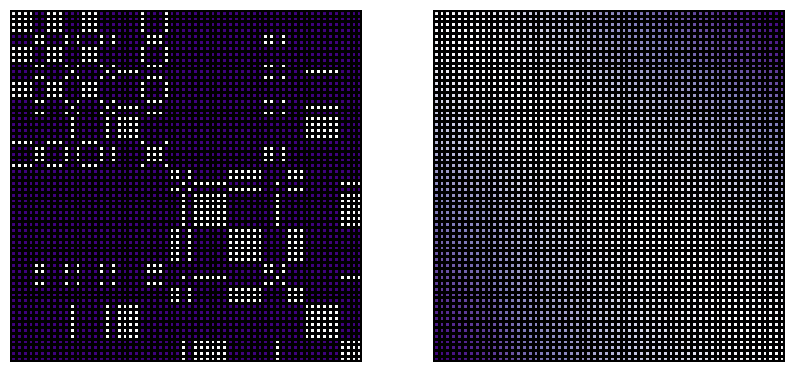

In [7]:
# plot the individual trials
onsets     = remove_neutrals(decision_trials['cogent_onset'].values)
onset_rdm  = pairwise_distances(onsets.reshape(-1, 1), metric='euclidean')
onset_rdv  = symm_mat_to_ut_vec(onset_rdm)

character_labels_ = remove_neutrals(character_labels)[:,np.newaxis]
character_rdm     = pairwise_distances(character_labels_)
character_id_rdm  = (character_rdm!=0)*1
character_id_rdv  = symm_mat_to_ut_vec(character_id_rdm)

# plot it
fig, axs = plt.subplots(1,2, figsize=(10,5))
plot_rdm(character_id_rdm, vmax=1, ax=axs[0])
plot_rdm(onset_rdm, vmax=np.max(onset_rdm), ax=axs[1])
# onset_same = onset_rdv[dim_rdv==1]
# onset_diff = onset_rdv[dim_rdv==0]


In [8]:
taus    = []
sample  = []
combos_ = get_combos(range(1, 6))

# temporal distances
temp_distances = []
for combo in combos_:
    combo_0_onset = decision_trials[decision_trials['char_role_num']==combo[0]]['cogent_onset'].values[:,np.newaxis]
    combo_1_onset = decision_trials[decision_trials['char_role_num']==combo[1]]['cogent_onset'].values[:,np.newaxis]
    temp_distances.append(np.nanmean(cdist(combo_0_onset, combo_1_onset, metric='euclidean')))

# behavioral distances
fnames, _ = get_fnames('*/*beta*pkl', glm='lsa_decision_128hpf', ftype='subs')
for i, fname in enumerate(fnames):

    print(f'Processing {i+1}/{len(fnames)}', end='\r')
    sub_id = fname.split('/')[-1].split('_')[0]
    sample.append(data[data['sub_id']==int(sub_id)]['sample'].values[0])
    behav = load_behavior(sub_id, neutrals=False)
    behav_dists = []
    for combo in combos_:
        behav_0 = behav[behav['char_role_num']==combo[0]][['affil_coord', 'power_coord']].values
        behav_1 = behav[behav['char_role_num']==combo[1]][['affil_coord', 'power_coord']].values
        behav_dists.append(np.nanmean(cdist(behav_0, behav_1, metric='euclidean')))
    
    taus.append(kendalltau(behav_dists, temp_distances)[0])

w, p = wilcoxon(taus)
print(f'W={w}, p={p:.03f}')

taus_val  = np.array(taus)[np.array(sample)=='Validation']
w, p = wilcoxon(taus_val)
print(f'Validation: W={w}, p={p:.03f}')

taus_init = np.array(taus)[np.array(sample)=='Initial']
w, p = wilcoxon(taus_init)
print(f'Initial: W={w}, p={p:.03f}')

Found 50 subs files
W=319.5, p=0.002
Validation: W=122.5, p=0.007
Initial: W=50.0, p=0.130


# ROI

In [ ]:
# from scipy.spatial import procrustes
# from scipy.spatial.distance import cdist, euclidean, directed_hausdorff
# from frechetdist import frdist
# from fastdtw import fastdtw

# def pairwise_trajectory_distances(trajectories, metric='euclidean'):

#     # calculate some notion of distance between different trajectories, pairwise

#     # arguments:
#     # - trajectories: (n_trajectories, n_points, n_dimensions)
#     # - metric: what to compute
#     # returns: distance_matrix with shape = (n_trajectories, n_trajectories)
    
#     n_trajs = trajectories.shape[0]
#     distance_matrix = np.zeros((n_trajs, n_trajs))
#     for i, j in itertools.combinations(range(n_trajs), 2):
#         if metric == 'frechet':      d = frdist(trajectories[i], trajectories[j])
#         elif metric == 'dtw':        d = fastdtw(trajectories[i], trajectories[j], dist=euclidean)[0]
#         elif metric == 'hausdorff':  d = undirected_hausdorff(trajectories[i], trajectories[j])
#         elif metric == 'procrustes': d = procrustes(trajectories[i], trajectories[j])[2]
#         else:                        d = np.nanmean(cdist(trajectories[i], trajectories[j], metric=metric)) # mean of all distances
#         distance_matrix[i,j] = distance_matrix[j,i] = d
#     return distance_matrix


In [28]:
fnames, _ = get_fnames('*/*beta*pkl', glm='lsa_decision_128hpf', ftype='subs')
rois = ['L_HPC_thr25']
behav_metrics  = ['euclidean']
neural_metrics = ['correlation'] # 'procrustes'
tau_df = pd.DataFrame(columns=['sub_id', 'roi', 'neural_metric', 'behav_metric', 'tau'])
for i, fname in enumerate(fnames):

    print(f'Processing {i+1}/{len(fnames)}', end='\r')
    sub_id     = fname.split('/')[-1].split('_')[0]
    behav      = load_behavior(sub_id, neutrals=False)
    beh_trajs  = organize_by_character(behav[['affil_coord', 'power_coord']].values)
    # beh_trajs  = np.array([traj[-1] for traj in beh_trajs])[:, np.newaxis]

    brain_dict = pd.read_pickle(fname)
    for roi in rois:

        # get neural trajectories
        betas        = preprocess_betas(brain_dict[roi], zscore=False, neutrals=False)
        neural_trajs = organize_by_character(betas)

        # embedding    = brain_dict[roi]['5d']['10nn']['embedding']
        # neural_trajs = organize_by_character(embedding)
        # neural_trajs = np.mean(neural_trajs, axis=1)[:, np.newaxis]

        # mean center the neural trajectories, to focus on shape?
        # neural_trajs = np.array([traj - np.mean(traj, axis=0) for traj in neural_trajs])
        # scale the neural trajectories, to focus on shape?
        # - divide by root mean square distance of points from the origin
        #neural_trajs = np.array([traj / np.sqrt(np.mean(np.sum(traj**2, axis=1))) for traj in neural_trajs])

        # loop through metrics
        for neural_metric, behav_metric in itertools.product(neural_metrics, behav_metrics):
            neural_rdv = symm_mat_to_ut_vec(pairwise_trajectory_distances(neural_trajs, metric=neural_metric))
            if neural_metric == 'correlation':
                neural_rdv = 1 - np.arctanh(1 - neural_rdv)
            beh_rdv = symm_mat_to_ut_vec(pairwise_trajectory_distances(beh_trajs, metric=behav_metric))
            tau_df.loc[len(tau_df)] = [sub_id, roi, neural_metric, behav_metric, kendalltau(neural_rdv, beh_rdv)[0]]

tau_df['sub_id'] = tau_df['sub_id'].astype(int)
tau_df = tau_df.merge(data, on='sub_id')

Found 50 subs files


In [29]:
res_df = pd.DataFrame(columns=['roi', 'neural_metric', 'behav_metric', 'tau', 'init_p', 'validation_p'])
for roi, nm, bm in itertools.product(rois, neural_metrics, behav_metrics):
    tau_df_ = tau_df[(tau_df['roi']==roi) & (tau_df['neural_metric']==nm) & (tau_df['behav_metric']==bm)]
    pvalues = []
    for sample in ['Initial', 'Validation']:
        taus = tau_df_[tau_df_['sample'] == sample]['tau'].values
        w, p = wilcoxon(taus, alternative='greater')
        pvalues.append(np.round(p, 5))
    res_df.loc[len(res_df), :] = [roi, nm, bm, np.mean(tau_df_['tau'])] + pvalues
res_df.sort_values(by='tau', ascending=False, inplace=True)
print_df(res_df)
# print_df(res_df[(res_df['init_p'] < 0.2) & (res_df['validation_p'] < 0.2)])

|    | roi         | neural_metric   | behav_metric   |       tau |   init_p |   validation_p |
|---:|:------------|:----------------|:---------------|----------:|---------:|---------------:|
|  0 | L_HPC_thr25 | correlation     | euclidean      | 0.0204444 |  0.66474 |        0.20523 |


Initial n=18
Validation n=32


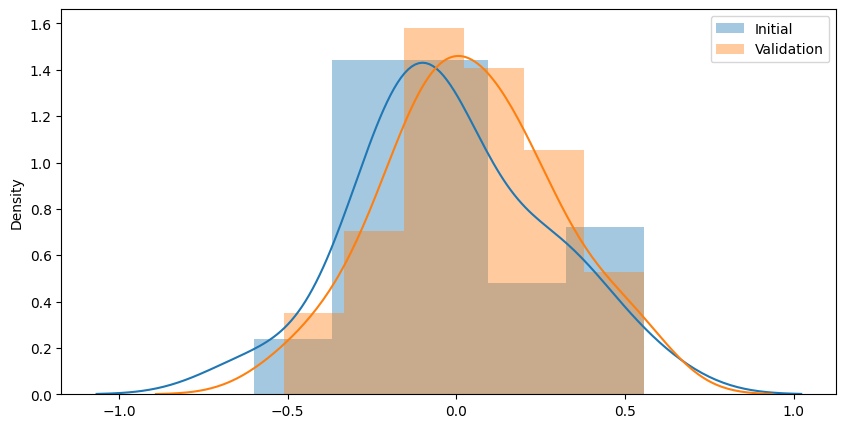

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
tau_df_ = tau_df[(tau_df['roi']=='L_HPC_thr25') & (tau_df['neural_metric']==nm) & (tau_df['behav_metric']==bm)]
for sample in ['Initial', 'Validation']:
    taus = tau_df_[tau_df_['sample'] == sample]['tau'].values
    print(f'{sample} n={len(taus)}')
    sns.distplot(taus, ax=ax, label=sample)
ax.legend()
plt.show()